In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

In [3]:

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

In [4]:
data_fls, ref_fls = LoadTroikaDataset()

In [5]:
data_fls
ref_fls

['./datasets/troika/training_data\\REF_01_TYPE01.mat',
 './datasets/troika/training_data\\REF_02_TYPE02.mat',
 './datasets/troika/training_data\\REF_03_TYPE02.mat',
 './datasets/troika/training_data\\REF_04_TYPE01.mat',
 './datasets/troika/training_data\\REF_04_TYPE02.mat',
 './datasets/troika/training_data\\REF_05_TYPE02.mat',
 './datasets/troika/training_data\\REF_06_TYPE02.mat',
 './datasets/troika/training_data\\REF_07_TYPE02.mat',
 './datasets/troika/training_data\\REF_08_TYPE02.mat',
 './datasets/troika/training_data\\REF_10_TYPE02.mat',
 './datasets/troika/training_data\\REF_11_TYPE02.mat',
 './datasets/troika/training_data\\REF_12_TYPE02.mat']

In [6]:
LoadTroikaDataFile('./datasets/troika/training_data\\DATA_12_TYPE02.mat')

array([[ -9.5   , -13.    , -15.5   , ...,  -3.    , -11.    , -22.5   ],
       [  0.117 ,   0.1248,   0.1482, ...,  -0.1326,  -0.1326,  -0.1248],
       [  0.2808,   0.2808,   0.2808, ...,   0.624 ,   0.624 ,   0.624 ],
       [  0.78  ,   0.7722,   0.78  , ...,   0.6318,   0.6084,   0.624 ]])

In [45]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

In [7]:
def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

### Code

In [8]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # Compute pulse rate estimates and estimation confidence.
    #Load PPG and Accelerometer Signals.  Get Freqs and FFT Spectra for PPG and Accelerometer signals.
    fs=125
    nfft_window = fs*8
    noverlap = fs*6
    
    filtered_ppg = BandpassFilter(ppg)
    filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filtered_ppg, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accx = BandpassFilter(accx)
    accx_specs, accx_freqs,_,_ = plt.specgram(filtered_accx, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accy = BandpassFilter(accy)
    accy_specs, accy_freqs,_,_ = plt.specgram(filtered_accy, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    
    filtered_accz = BandpassFilter(accz)
    accz_specs, accz_freqs,_,_ = plt.specgram(filtered_accz, NFFT = nfft_window, Fs=fs, noverlap=noverlap)
    plt.close()
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    errors, confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    ppg_max_freqs = []
    distance_bpm = 10
    distance_bps = distance_bpm/60
    count=0
    inner=0
    
    for i in range(filt_ppg_specs.shape[1]):
        accx_max_freq = accx_freqs[np.argmax(accx_specs[:,i])]
        accy_max_freq = accy_freqs[np.argmax(accy_specs[:,i])]
        accz_max_freq = accz_freqs[np.argmax(accz_specs[:,i])]
        sorted_ppg_specs = np.sort(filt_ppg_specs[:,i])[::-1]
        count += 1
        #for f in range(filt_ppg_specs.shape[0]):
        for f in range(10):
            ppg_freq = filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[f]))[0][0]]
            inner+=1
            if ppg_freq == 0:
                continue
            elif (np.abs(ppg_freq-accx_max_freq)<=distance_bps) or (np.abs(ppg_freq-accy_max_freq)<=distance_bps) or (np.abs(ppg_freq-accz_max_freq)<=distance_bps):
                #if f == (filt_ppg_specs.shape[0]-1):
                if f == 9:
                    ppg_max_freqs.append(filt_ppg_freqs[np.argwhere(filt_ppg_specs == (sorted_ppg_specs[0]))[0][0]])
                continue
            else:
                ppg_max_freqs.append(ppg_freq)
                break
    """
    Compute Confidence Estimation:
    - For this computation, The energy in the frequency spectrum that is concentrated near the pulse rate estimate is
    determined by summing the frequency spectrum around the pulse rate estimate with a window of bpm_sum_window.
    - The bpm_sum_window will be chosen to be less than the performance criterion of 15BPM difference 
    between estimated pulse rate and reference pulse rate.
    - The Confidence Estimate is the Energy around the Pulse Rate Estimate divided by the sum of the 
    entire frequency spectrum.
    """
    
    bpm_sum_window = 10
    bps_sum_window = bpm_sum_window/60
    
    ecgdata = sp.io.loadmat(ref_fl)['BPM0']
    
    confidences = []
    for i in range(filt_ppg_specs.shape[1]):
        low_window = ppg_max_freqs[i]-bps_sum_window 
        high_window = ppg_max_freqs[i] + bps_sum_window
        window = (filt_ppg_freqs>= low_window) & (filt_ppg_freqs<=high_window)
        confidence=np.sum(filt_ppg_specs[:,i][window])/np.sum(filt_ppg_specs[:,i])
        error = np.abs(ppg_max_freqs[i]*60-ecgdata[i][0])
        confidences.append((i, ppg_max_freqs[i]*60, ecgdata[i][0], confidence, error))

    confidence_df = pd.DataFrame(
                    data=confidences, 
                    columns=['WindowNumber','Estimated_Pulse_Rate','Ref_BPM','Confidence','Error'])
    
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
  
    errors = confidence_df['Error'].values
    confidence = confidence_df['Confidence'].values
    
    return errors, confidence

In [9]:
Evaluate ()

NameError: name 'BandpassFilter' is not defined

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

## Code Description:

The code is an algorithm that estimates pulse rate from PPG signal measurements and measurements from a 3-axis accelerometer. 

Inputs:
.mat files with  ECG,PPG, and accelerometer measurements
.mat files with ground truth pulse rates calculated from ECG measurements
All files should be in same folder directory "./datasets/troika/training_data"

To start, the function LoadTroikaDataset() will return two lists:

    datafls which contain a list of all files with a name starting with 'DATA' in the directory
    reffls which containa a list of all files with a name starting with 'REF' in the directory.

Next, the function LoadTroikaDataFile(data_fl) will load a data file path and return a np.array with PPG and 3-axis accelerometer measurements.

Next, the function RunPulseRateAlgorithm(data_fl, ref_fl), will accept a data file path and a corresponding reference file path. It will load the data file.
To process the PPG and individual accelerometer signals, each signal is first band passed through a 40BPM to 240BPM filter (0.66Hz and 40Hz respectively). Next, characteristic frequencies for each signal are calculated in 8 second windows with 6 second overlap between adjacent windows so the project meets one of the criteria of specification of 2 secs.
.
Characteristic frequencies for the PPG data is compared against the dominant characteristic frequencies for each accelerometer axis per time window. A dominant PPG characteristic frequency may be similar to accelerometer frequencies. Once the PPG's frequency is determined, it is converted from Beats per second to Beats per minute. The Confidence of each frequency's determination is calulated as intensity magnitudes near the charactistic frequncy divided by the sum of intensity magnitudes across all frequenciesas as per the code above.

Finally, the absolute error between the determined PPG frequency and the reference ECG pulse rate data are calculated. The errors and confidences are returned from this function

Lastly, the Top-level function Evaluation() will load dataset and run the RunPulseRateAlgorithm. Additionally, it will run the AggregateErrorMetric function to determine the mean absolute error of 90% availability of the output from RunPulseRateAlgorithm.

## Data Description:

The dataset used to train this algorithm is from Z. Zhang, Z. Pi, and B.Liu's paper "TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise." In their study, 12 subjects aged 18 to 35 were monitored as each subject ran on a treadmill with changing speeds for 5 minutes in this interval:
Rest(30s)-> 6 or 8km/h(1min) -> 12 or 15km/h(1min) -> 6 or 8km/h(1min) -> 12 or 15km/h(1min) -> Rest(30s)
Two-channel PPG signals, 3-axis accelerometer signals, and one-channel ECG signals were simultaneously recorded. All signals were sampled at 125Hz.

The signal data are contained in files named 'DATA_XX_TYPEXX'. Each file has 6 rows: Row1 ECG data, Rows 2 and 3 are the two channels of PPG; and Rows 4,5, and 6 are the x-, y-, and z-axis accelerometer measurements.
Z.Zhang et al also provide ground truth pulse rates in files named 'REF_XX_TYPEXX'. The ground truth is calculated from the ECG data in the data files. Z.Zhang et al calculate the ground truth pulse rates with every 8-second window and overlap of 6-seconds.

The dataset is limited in its number of subjects and age range. The age of each subject is not provided. Furthermore, the duration of each activity is a limited duration.
For further work, a more complete dataset would include a larger dataset with a larger age range. Subjects' demographics such as age and gender may allow additional insights. Lastly, the recorded activity durations should be lengthened to allow physiological changes to be revealed.
Algorithm Description:

This algorithm uses information from Photoplethysmography (PPG) sensors worn on a user's wrist to estimate pulse rate. PPG sensors emit light into a user's wrist and detects the amount of light reflecting back to the PPG's photodector. The physiological aspect that a PPG measures is the amount of blood cells in one area.
When the heart contracts, blood fills the extremities. When the heart relaxes, blood leaves the extremities and fill the heart. PPG readings are high when the heart contracts and PPG readings are lower when the heart relaxes. The heart beats are typically a steady pulse rhythm, so these readings form a waveform whose period can be used to determine the pulse rate.

In addition to the heart contractions, arm motions cause blood movement through the wrist. When running or walking, the arm movement can add another cadence to the PPG sensor measurements. These movements tend to be periodic and can be separately measured with 3-axis accelerometers.

In this project, PPG sensor information is used to estimate pulse rates of subjects who are running at different speeds. To separate arm movements from pulse rate information, 3-axis accelerometer measurements are used to remove characteristic waves frequencies belonging to arm movements.

## Outputs:

    Characteristic frequencies for the PPG data is compared against the dominant characteristic frequencies for each accelerometer axis per time window. A dominant PPG characteristic frequency may be similar to accelerometer frequencies. Once the PPG's frequency is determined, it is converted from Beats per second to Beats per minute.

    The Confidence of each frequency's determination is calulated as intensity magnitudes near the charactistic frequncy divided by the sum of intensity magnitudes across all frequencies. This method to calculate confidence is similar to Signal to Noise ratio calculation, where a higher result indicates fewer noise frequencies that are not characteristic of the pulse rate. One may select BPM estimates above a threshold confidence while discarding those below the threshold.
    The Absolute Errors are calculated between the determined PPG frequency and the reference ECG pulse rate data.

The output from this algorithm only takes into account arm movement noise that is periodic.
It doesn't remove non-periodic movements.
This algorithm also doesn't account for other noise sources such as ambient light or shifts in sensor position.

## Algorithm Performance:

This algorithm meets the project's requirement that the mean absolute error at 90% availability is less than 15BPM on the test dataset as shown in the measurment output of 7.55 in the test data set as evidanced by the PNG screen shot.
Using the Troika training dataset,
a) the Evaluate() command shows that the error is 11.9595.
b)With the test dataset, the error is 7.55.



In [10]:
-----
### Next Steps
You will now go to **Test Your Algorithm** (back in the Project Classroom) to apply a unit test to confirm that your algorithm met the success criteria. 

SyntaxError: invalid syntax (957353869.py, line 1)

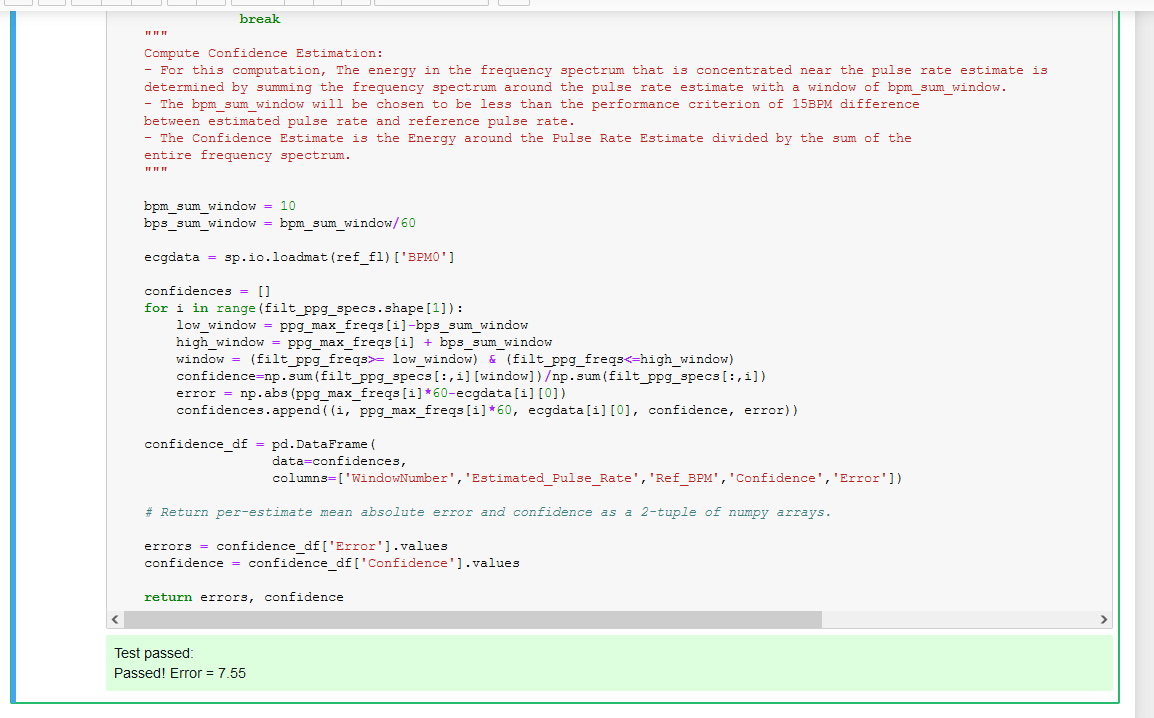

EDA

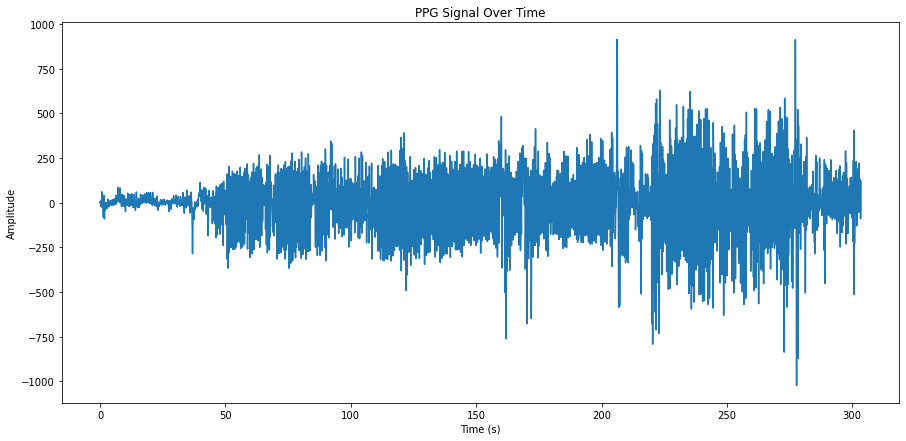

In [11]:
fs = 125
window = 2

ds, ref = LoadTroikaDataset()
ds1 = ds[0]
ds1 = LoadTroikaDataFile(ds1)
ds1
ppg, accx, accy, accz = ds1
ts = np.arange(0,len(ppg)/fs,1/fs)
plt.figure(figsize=(15,7))
plt.plot(ts,ppg)
plt.title("PPG Signal Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

In [12]:
errors, confidence= RunPulseRateAlgorithm(ds[0],ref[0])
confidence

array([0.35439383, 0.58005256, 0.56318607, 0.37266692, 0.58690027,
       0.61747349, 0.26978525, 0.33623003, 0.56854565, 0.53120958,
       0.13586463, 0.39659506, 0.44304966, 0.43482781, 0.11329174,
       0.07609913, 0.10002745, 0.30885978, 0.21213171, 0.34507665,
       0.43885097, 0.2803305 , 0.21765426, 0.24530357, 0.31006569,
       0.28959901, 0.03764732, 0.21106872, 0.16800812, 0.01055561,
       0.26440555, 0.20012874, 0.31394434, 0.28439867, 0.43456235,
       0.019887  , 0.3660794 , 0.09427243, 0.1923879 , 0.40131066,
       0.35534855, 0.29227465, 0.25051372, 0.39737203, 0.20677698,
       0.30535221, 0.30903586, 0.30975096, 0.32122411, 0.40505008,
       0.57951987, 0.39432262, 0.30909309, 0.20092799, 0.4960091 ,
       0.24006246, 0.01298354, 0.02578087, 0.5568392 , 0.20732801,
       0.07166786, 0.2436924 , 0.27809976, 0.02901352, 0.03343381,
       0.39928871, 0.38974526, 0.0195015 , 0.0277559 , 0.01495267,
       0.01664249, 0.01942499, 0.04899125, 0.29501176, 0.22039

In [13]:
filtered_ppg = BandpassFilter(ppg)

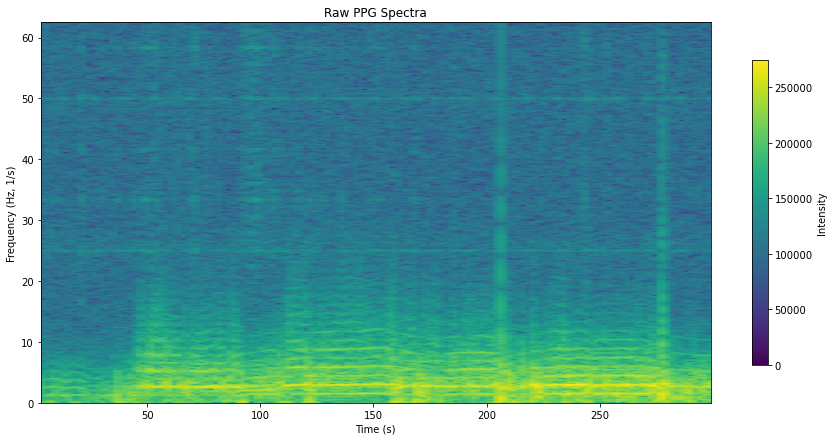

In [14]:
plt.figure(figsize=(15,7))

ppg_specs, ppg_freqs,_,ppg_im = plt.specgram(ppg, NFFT = fs*8, Fs=fs, noverlap=fs*6)

plt.title("Raw PPG Spectra")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz, 1/s)")

norm = mpl.colors.Normalize(vmin=np.min(ppg_specs), vmax=np.max(ppg_specs))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm), shrink=0.8, label='Intensity')

plt.show()

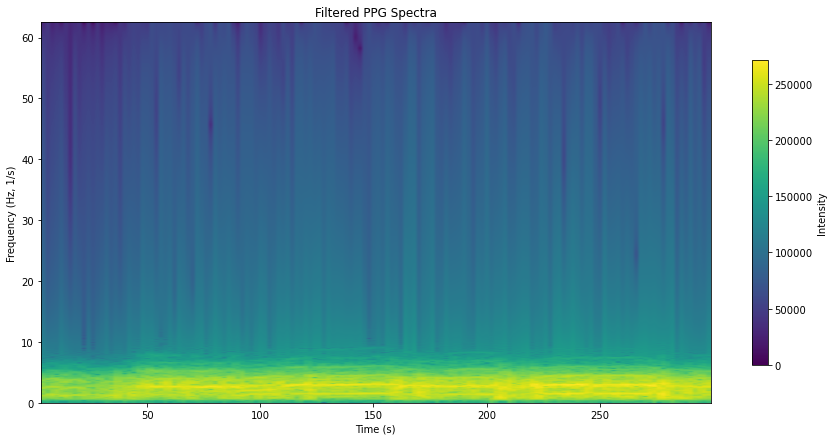

In [15]:
plt.figure(figsize=(15,7))

filt_ppg_specs, filt_ppg_freqs,_,filt_ppg_im = plt.specgram(filtered_ppg, NFFT = fs*8, Fs=fs, noverlap=fs*6)

plt.title("Filtered PPG Spectra")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz, 1/s)")

norm = mpl.colors.Normalize(vmin=np.min(filt_ppg_specs), vmax=np.max(filt_ppg_specs))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm), shrink=0.8, label='Intensity')

plt.show()

In [16]:
np.max(filt_ppg_specs, axis=0)[0:20]

array([ 213.25135292,  583.17119602,  921.96452538,  741.065455  ,
        993.20802929, 1380.04535554,  764.98689822,  699.54685576,
        792.06181887,  635.58006926,  274.08594617,  157.31699719,
        361.84319245,  394.22533726, 1451.19988759, 2267.61980831,
       3753.3934492 , 1672.38808104,  586.38944984, 2432.84378823])

In [17]:
np.argmax(filt_ppg_specs, axis=0)

array([10, 10, 10, 10,  9,  9, 10, 10, 10, 10, 11, 11, 10,  9,  9, 10, 10,
        9, 15, 11, 10, 21, 22, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       20, 20, 21, 21, 21, 21, 21, 21, 21, 20, 20, 22, 22, 22, 22, 17, 17,
       17, 26, 21, 22, 23, 23, 23, 24, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 21, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 21, 21, 21, 22, 22, 23, 22, 22, 22, 22, 22, 22,  7,
       19, 19, 17, 20, 20, 21, 23, 24, 20, 23, 23, 23, 24, 23, 23, 23, 24,
       24, 24, 21, 22, 22, 24, 24, 23, 24, 24, 24, 24, 23, 24, 23, 23, 22,
       12, 11, 25, 22, 22,  6, 21, 21, 21, 20, 21, 21], dtype=int64)

In [18]:
# Understand the intensity for each frequency in the last (148th) specgram time window

filt_df = pd.DataFrame({'Freq':filt_ppg_freqs,'IntensityWindow148':filt_ppg_specs[:,147]})
filt_df.sort_values('IntensityWindow148',ascending=False)

Freq  IntensityWindow148
21    2.625        2.999039e+04
20    2.500        1.576679e+04
26    3.250        5.789656e+03
23    2.875        5.321304e+03
22    2.750        5.148770e+03
..      ...                 ...
496  62.000        1.869547e-16
497  62.125        1.108452e-16
498  62.250        5.658832e-17
499  62.375        2.407705e-17
500  62.500        6.623561e-18

[501 rows x 2 columns]

In [19]:
sorted_ppg_spec_148 = np.sort(filt_ppg_specs[:,147])[::-1]
sorted_ppg_spec_148

array([2.99903944e+04, 1.57667903e+04, 5.78965598e+03, 5.32130384e+03,
       5.14876978e+03, 2.91247545e+03, 2.34271856e+03, 1.97643153e+03,
       1.94486293e+03, 1.58689203e+03, 1.45288383e+03, 1.24777013e+03,
       1.10538793e+03, 7.93723173e+02, 7.30758705e+02, 5.97569479e+02,
       4.18743266e+02, 3.59268770e+02, 3.44277496e+02, 2.22361577e+02,
       2.03332305e+02, 1.65696997e+02, 1.18514148e+02, 8.83755837e+01,
       8.71515010e+01, 3.01891268e+01, 2.11434393e+01, 2.02815859e+01,
       1.83754881e+01, 1.51246345e+01, 6.51110759e+00, 3.94150106e+00,
       1.32918602e+00, 7.77340777e-01, 4.08395110e-01, 3.15706266e-01,
       2.90009795e-01, 2.51068209e-01, 2.09037426e-01, 1.82094356e-01,
       1.59837215e-02, 1.30044320e-02, 1.04985601e-02, 1.00924584e-02,
       2.90071454e-03, 2.32930546e-03, 2.23671524e-03, 1.94562659e-03,
       2.74185049e-04, 2.66522273e-04, 1.71757249e-04, 6.21043386e-05,
       4.86228472e-05, 2.10467929e-05, 1.18765291e-05, 1.08877636e-05,
      

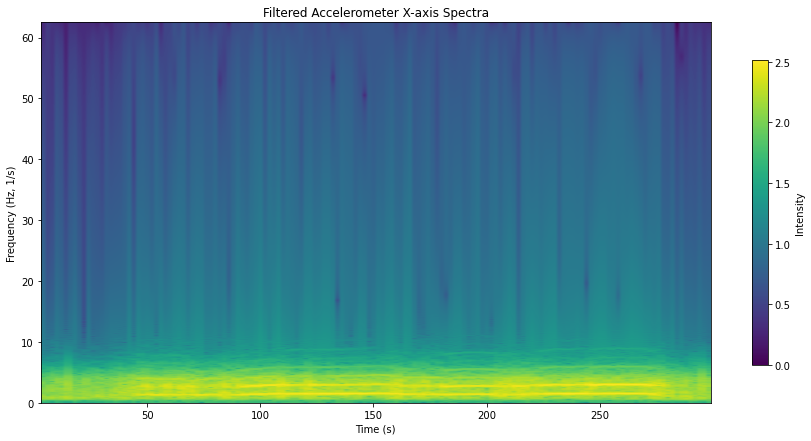

In [20]:
filtered_accx = BandpassFilter(accx)

plt.figure(figsize=(15,7))

accx_specs, accx_freqs,_,accx_im = plt.specgram(filtered_accx, NFFT = fs*8, Fs=fs, noverlap=fs*6)

plt.title("Filtered Accelerometer X-axis Spectra")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz, 1/s)")

norm = mpl.colors.Normalize(vmin=np.min(accx_specs), vmax=np.max(accx_specs))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm), shrink=0.8, label='Intensity')

plt.show()

In [21]:
np.max(accx_specs, axis=0)

array([1.00506683e-03, 9.76661158e-04, 2.33813559e-03, 9.34248248e-04,
       1.97446142e-03, 6.43884875e-03, 4.18645350e-03, 8.94118783e-04,
       1.84995012e-03, 2.30989991e-03, 8.70530782e-04, 1.29451060e-03,
       5.23023462e-03, 3.93021857e-03, 2.05932650e-03, 3.85032605e-03,
       5.93785677e-03, 6.77413852e-03, 9.40100686e-03, 6.60454872e-03,
       1.42058305e-02, 9.45339750e-02, 1.45339612e-01, 2.70774009e-01,
       3.53060075e-01, 4.09079874e-01, 3.77052110e-01, 2.31615002e-01,
       1.80711479e-01, 2.26343611e-01, 2.21600600e-01, 1.78187590e-01,
       1.98507757e-01, 2.19498801e-01, 4.34708032e-01, 4.81891619e-01,
       3.43860526e-01, 2.42146293e-01, 2.09613795e-01, 2.21430290e-01,
       1.29669344e-01, 9.51525849e-02, 2.15060104e-01, 3.46484549e-01,
       5.70349171e-01, 7.84557341e-01, 1.21348265e+00, 1.34756059e+00,
       1.17542349e+00, 1.35205275e+00, 1.58743626e+00, 1.45365909e+00,
       1.03946308e+00, 8.20164716e-01, 8.07599760e-01, 9.65365230e-01,
      

In [22]:
accx_freqs[np.argmax(accx_specs, axis=0)]

array([1.   , 0.875, 0.875, 0.875, 1.   , 0.875, 0.75 , 0.875, 0.875,
       0.75 , 0.75 , 0.875, 1.   , 1.   , 1.   , 1.25 , 1.25 , 1.75 ,
       1.625, 1.875, 1.5  , 1.375, 1.375, 1.375, 1.375, 1.25 , 1.25 ,
       1.375, 1.375, 1.25 , 1.25 , 1.375, 2.625, 1.25 , 1.25 , 1.25 ,
       1.25 , 1.375, 1.375, 1.25 , 1.625, 1.375, 1.25 , 1.25 , 1.375,
       1.375, 2.75 , 2.75 , 2.75 , 2.875, 2.875, 2.875, 1.5  , 1.5  ,
       1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  ,
       1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  ,
       1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.5  , 1.375, 1.375,
       1.375, 1.375, 1.375, 1.375, 1.375, 1.375, 1.375, 2.75 , 2.625,
       1.375, 1.375, 2.75 , 1.375, 1.375, 1.375, 1.375, 1.375, 1.375,
       1.375, 2.75 , 2.75 , 1.25 , 1.375, 2.75 , 2.75 , 2.75 , 2.75 ,
       1.375, 1.5  , 2.875, 2.875, 1.5  , 1.5  , 1.5  , 1.5  , 1.5  ,
       1.5  , 1.5  , 1.5  , 1.5  , 2.875, 2.875, 3.   , 3.   , 3.   ,
       3.   , 3.   ,

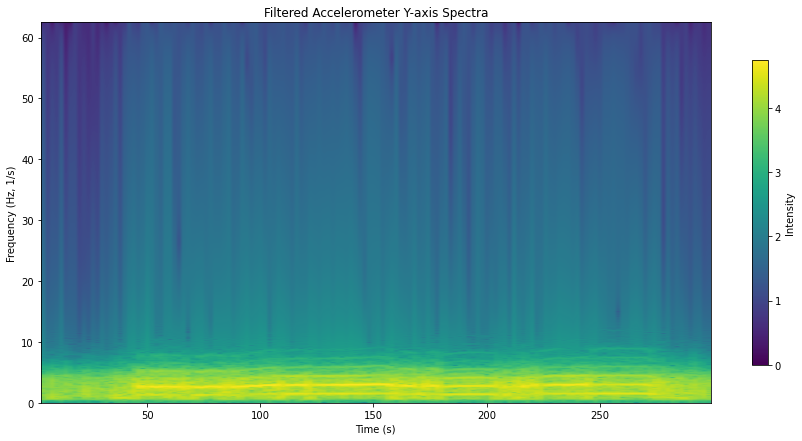

In [23]:
filtered_accy = BandpassFilter(accy)

plt.figure(figsize=(15,7))

accy_specs, accy_freqs,_,accy_im = plt.specgram(filtered_accy, NFFT = fs*8, Fs=fs, noverlap=fs*6)

plt.title("Filtered Accelerometer Y-axis Spectra")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz, 1/s)")

norm = mpl.colors.Normalize(vmin=np.min(accy_specs), vmax=np.max(accy_specs))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm), shrink=0.8, label='Intensity')

plt.show()

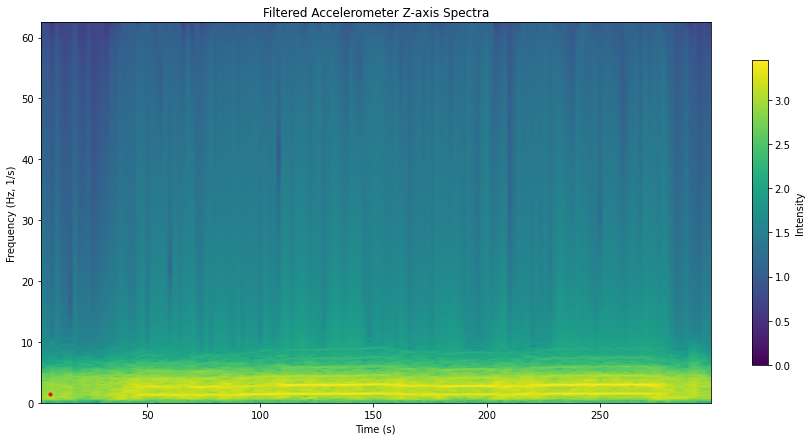

In [24]:
filtered_accz = BandpassFilter(accz)

plt.figure(figsize=(15,7))

accz_specs, accz_freqs,_,accz_im = plt.specgram(filtered_accz, NFFT = fs*8, Fs=fs, noverlap=fs*6)

plt.plot(7,1.5,'.r')

plt.title("Filtered Accelerometer Z-axis Spectra")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz, 1/s)")

norm = mpl.colors.Normalize(vmin=np.min(accz_specs), vmax=np.max(accz_specs))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm), shrink=0.8, label='Intensity')

plt.show()